<a href="https://colab.research.google.com/github/KazumaIwase/Interpolation-of-mountain-weather-forecasts-/blob/main/notebooks/training_nofuture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training LightGBM(that do not use future forecast data)

Prediction object
*   Temperature prediction for Mt.Fuji
*   Precipitation prediction for Hakone

Model
*   Models trained on data of all features(LightGBM all feature)
*   Models trained on data with only important features(LightGBM)

In [1]:
!pip install optuna==3.2.0
!pip install lightgbm==3.3.5

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna
import glob
import math

import seaborn as sns
sns.set()

import warnings
warnings.simplefilter('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Num GPUs Available:  0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4167682901202853529
 xla_global_id: -1]

In [3]:
!pwd

!git clone https://$$TOKEN@github.com/KazumaIwase/Interpolation-of-mountain-weather-forecasts-.git

!ls
%cd Interpolation-of-mountain-weather-forecasts-
!ls

/content
Cloning into 'Interpolation-of-mountain-weather-forecasts-'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 105 (delta 45), reused 59 (delta 17), pack-reused 0
Receiving objects: 100% (105/105), 7.11 MiB | 6.35 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Interpolation-of-mountain-weather-forecasts-  sample_data
/content/Interpolation-of-mountain-weather-forecasts-
data  dataset_tools  model  notebooks  README.md  utils


In [4]:
dataset = pd.read_csv('data/observe.csv', header=0, index_col=0, parse_dates=True)
news_data = pd.read_csv('data/dummy_nesw.csv', header=0, index_col=0, parse_dates=True)
f3144_data = pd.read_csv('data/dummy_tenki_to_kurasu.csv', header=0, index_col=0, parse_dates=True)

In [5]:
import utils.common_utils as co
import model.model as model
import dataset_tools.make_dataset as md

# Temperature prediction for Mt.Fuji

In [6]:
# Make data for your work
# The prediction time can be set from 2, 7, 8, or 9 hours ahead

# 2 hours ahead
h='(2h)'
t='09:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_2h_nofuture,t)

'''
# 7 hours ahead
h='(7h)'
t='14:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_7h_nofuture,t)

# 8 hours ahead
h='(8h)'
t='15:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_8h_nofuture,t)

# 9 hours ahead
h='(9h)'
t='16:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_9h_nofuture,t)
'''

"\n# 7 hours ahead\nh='(7h)'\nt='14:00:00'\nmf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_7h_nofuture,t)\n\n# 8 hours ahead\nh='(8h)'\nt='15:00:00'\nmf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_8h_nofuture,t)\n\n# 9 hours ahead\nh='(9h)'\nt='16:00:00'\nmf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_no_future_dataset(dataset,md.get_data_mtfuji_9h_nofuture,t)\n"

## lightgbm_all_feature

In [7]:
def bayes_objective_mt(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
            'max_depth': trial.suggest_int('max_depth', 5, 10, step=1)
        }
        val = co.get_scores(Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val
    return objective

fixed_params = {'patience' : 10,
                'verbose' : 0,
                'objectiive': 'regression',
                'n_estimators': 10000}

runner_lgall = co.Runner(model.Lgbm, mf_train_x_all, mf_train_y)
runner_lgall.run_opt(bayes_objective_mt, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 12:57:36,783] A new study created in memory with name: no-name-9f0c9465-0f39-49ab-b0b4-7a8370f8c58a
[I 2023-08-25 12:57:39,009] Trial 0 finished with value: 1.1404795322261343 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.1404795322261343.
[I 2023-08-25 12:57:41,025] Trial 1 finished with value: 1.4126565027855975 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.1404795322261343.
[I 2023-08-25 12:57:42,678] Trial 2 finished with value: 1.1471073044907831 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.1404795322261343.
[I 2023-08-25 12:57:44,547] Trial 3 finished with value: 1.1621061349087431 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 

best params {'num_leaves': 25, 'colsample_bytree': 0.8, 'subsample': 0.9, 'min_child_samples': 21, 'max_depth': 8}
best score 1.135


RMSE 1.126226470434698


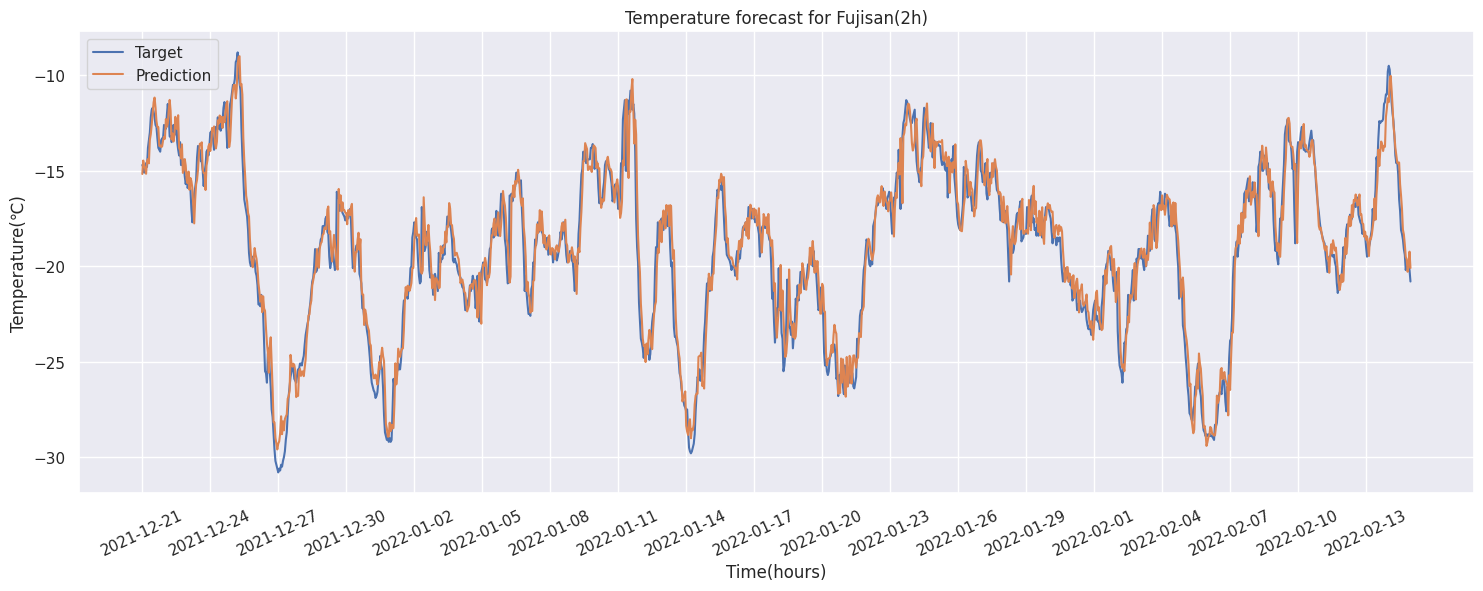

RMSE 1.1606502506482417


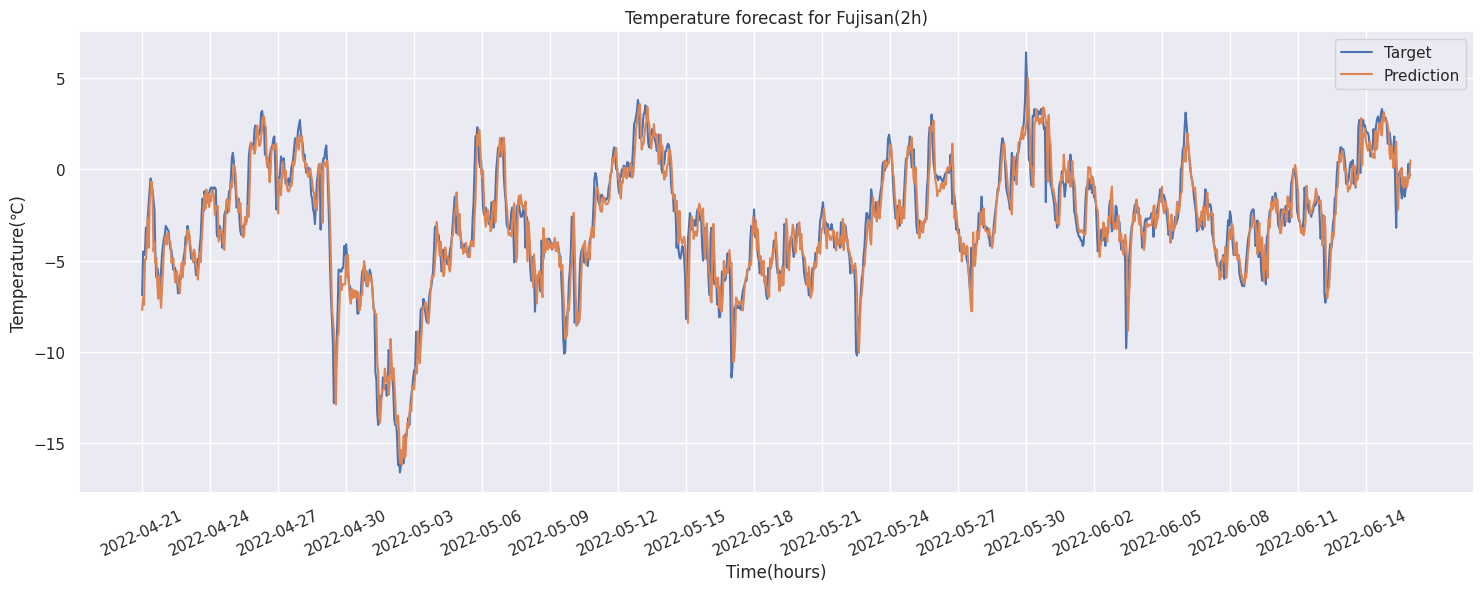

RMSE 1.1182635151256184


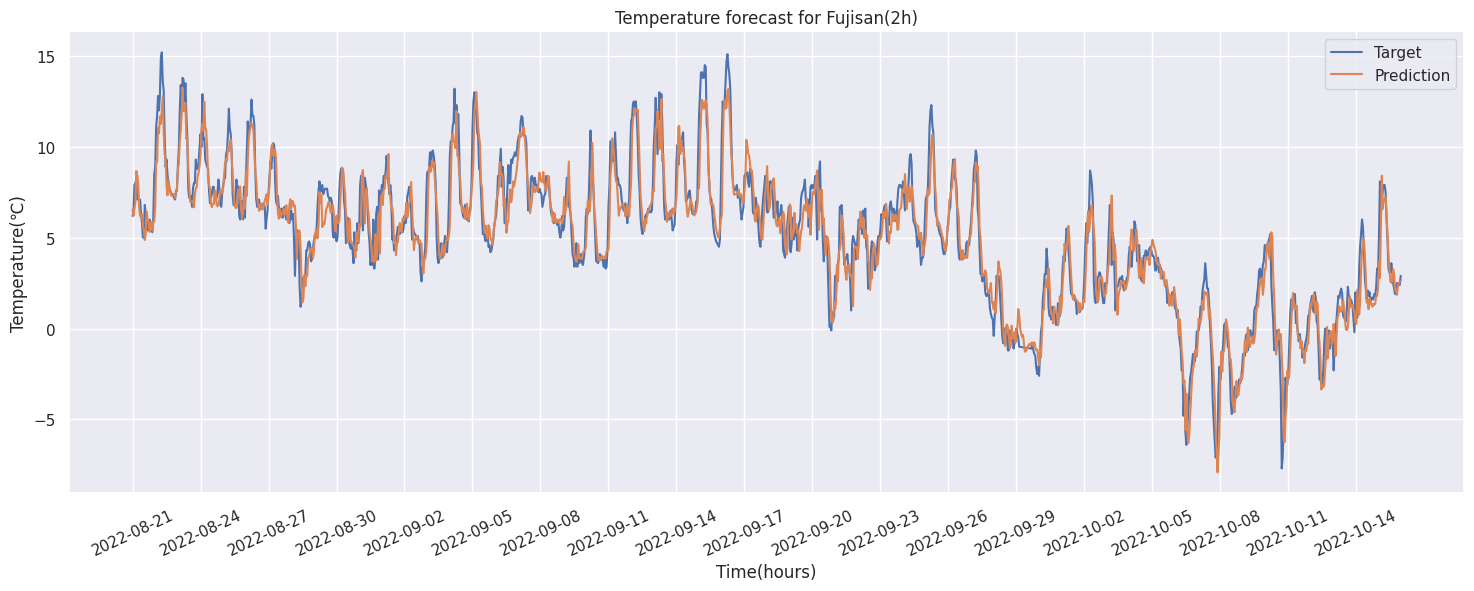

In [8]:
fixed_params = {'patience' : 15,
                'verbose' : 10,
                'n_estimators' : 10000}

runner_lgall.run_val(fixed_params, p='f', h=h)

In [9]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True,
                'seed' : 42}

runner_lgall.run_train_all(fixed_params)

### Prediction using forecast data

In [10]:
# 2 or 8 hours ahead
testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test(runner_lgall.model, news_data, f3144_data, mf_test_x.columns, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse

'''
# 7 or 9 hours ahead
testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test_without_f3144(runner_lgall.model, news_data, mf_test_x.columns, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse
'''

"\n# 7 or 9 hours ahead\ntestrun = co.TestRun(mf_test_x, mf_test_y)\ntestrun.runf_test_without_f3144(runner_lgall.model, news_data, mf_test_x.columns, ts_time=t, loc='Temperature_Fujisan')\ntestrun.df_rmse\n"

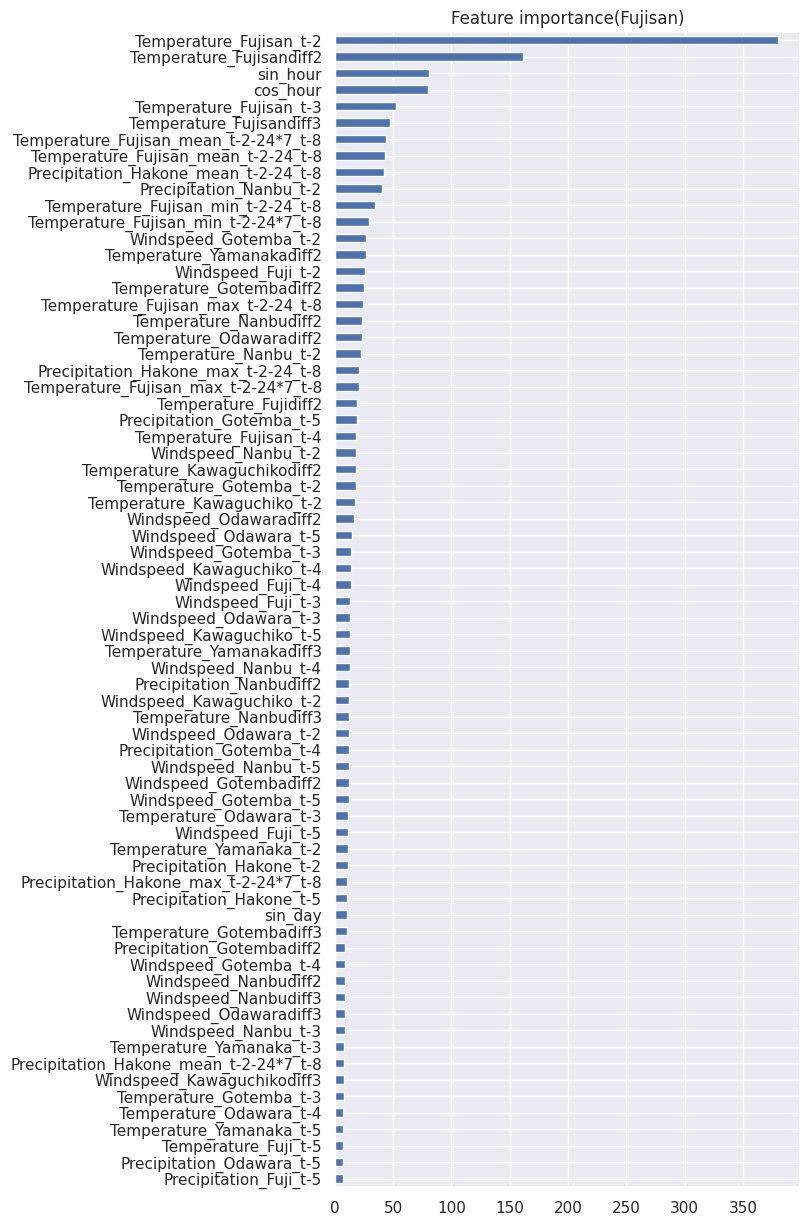

In [11]:
runner_lgall.run_importanace(title='Feature importance(Fujisan)', figsize=(6,15), top=70)

In [12]:
runner_lgall.top_cols = np.union1d(np.array(['sin_day', 'cos_day', 'sin_hour', 'cos_hour']), runner_lgall.top_cols)
mf_train_x_top = mf_train_x_all[runner_lgall.top_cols]
mf_train_x_top.head()

,Precipitation_Fuji_t-5,Precipitation_Gotemba_t-4,Precipitation_Gotemba_t-5,Precipitation_Gotembadiff2,Precipitation_Hakone_max_t-2-24*7_t-8,Precipitation_Hakone_max_t-2-24_t-8,Precipitation_Hakone_mean_t-2-24*7_t-8,Precipitation_Hakone_mean_t-2-24_t-8,Precipitation_Hakone_t-2,Precipitation_Hakone_t-5,...,Windspeed_Nanbudiff3,Windspeed_Odawara_t-2,Windspeed_Odawara_t-3,Windspeed_Odawara_t-5,Windspeed_Odawaradiff2,Windspeed_Odawaradiff3,cos_day,cos_hour,sin_day,sin_hour
2019-07-03 15:00:00,0.0,0.0,0.0,0.0,28.5,0.0,1.083333,0.0,0.0,0.0,...,-0.3,2.4,2.5,2.5,-0.1,-0.2,0.998667,-7.071068e-01,0.05162,-0.707107
2019-07-03 16:00:00,0.0,0.0,0.0,0.0,28.5,0.0,1.083333,0.0,0.0,0.0,...,0.4,1.7,2.4,2.7,-0.7,-0.1,0.998667,-5.000000e-01,0.05162,-0.866025
2019-07-03 17:00:00,0.0,0.0,0.0,0.0,28.5,0.0,1.083333,0.0,0.0,0.0,...,-0.4,1.9,1.7,2.5,0.2,-0.7,0.998667,-2.588190e-01,0.05162,-0.965926
2019-07-03 18:00:00,0.0,0.0,0.0,0.0,28.5,0.0,1.083333,0.0,0.0,0.0,...,-0.7,1.6,1.9,2.4,-0.3,0.2,0.998667,-1.836970e-16,0.05162,-1.000000
2019-07-03 19:00:00,0.0,0.0,0.0,0.0,28.5,0.0,1.083333,0.0,0.0,0.0,...,0.2,1.6,1.6,1.7,0.0,-0.3,0.998667,2.588190e-01,0.05162,-0.965926


## lightgbm

In [13]:
fixed_params = {'patience' : 10,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_lgtop = co.Runner(model.Lgbm, mf_train_x_top, mf_train_y)
runner_lgtop.run_opt(bayes_objective_mt, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 13:01:34,475] A new study created in memory with name: no-name-e3db09c7-b70c-4433-b943-529a342597de
[I 2023-08-25 13:01:35,703] Trial 0 finished with value: 1.1379316049653487 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.1379316049653487.
[I 2023-08-25 13:01:36,945] Trial 1 finished with value: 1.279906331662607 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.1379316049653487.
[I 2023-08-25 13:01:38,201] Trial 2 finished with value: 1.1450502875730664 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.1379316049653487.
[I 2023-08-25 13:01:39,149] Trial 3 finished with value: 1.1550020172367572 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, '

best params {'num_leaves': 29, 'colsample_bytree': 0.9500000000000001, 'subsample': 0.25, 'min_child_samples': 38, 'max_depth': 7}
best score 1.133


RMSE 1.1288897356761336


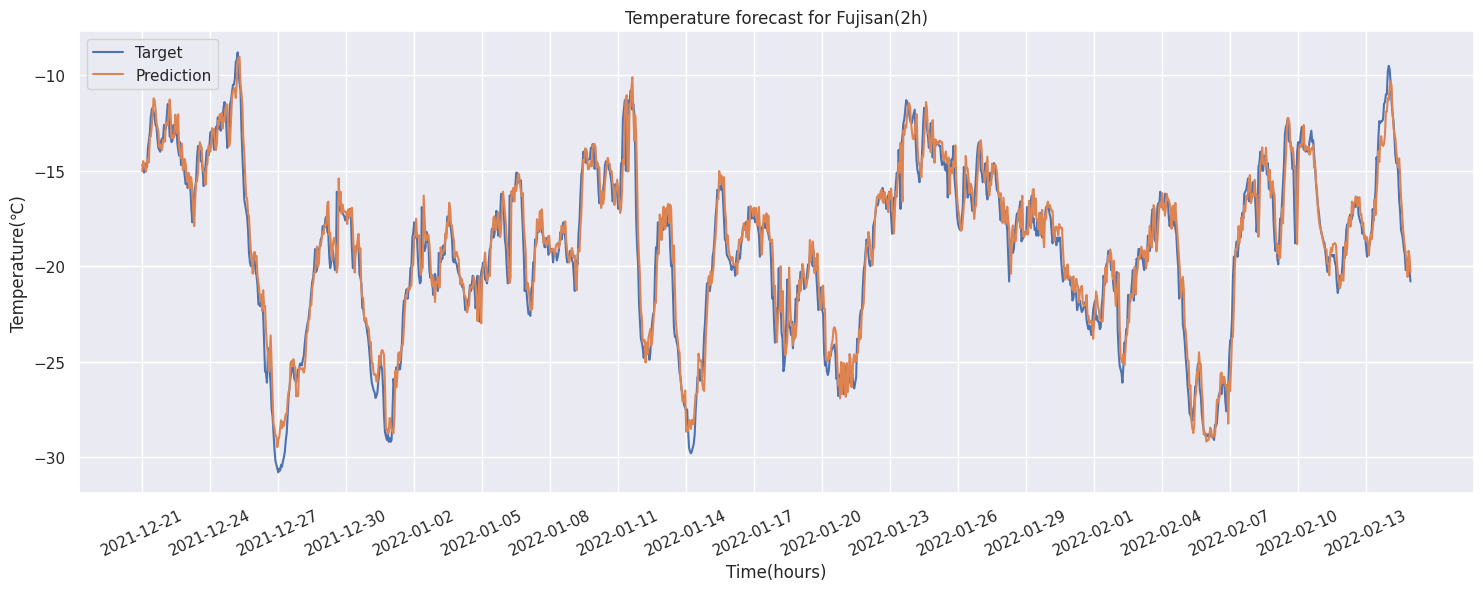

RMSE 1.158802361786304


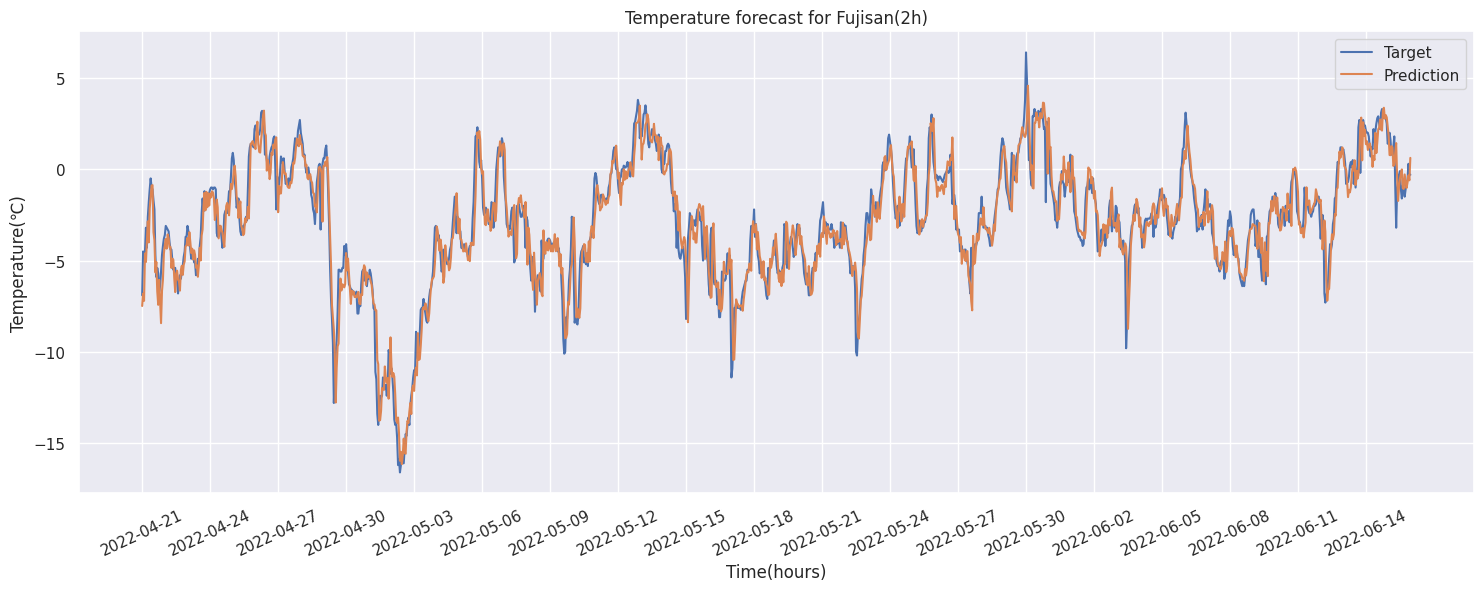

RMSE 1.1110249677094597


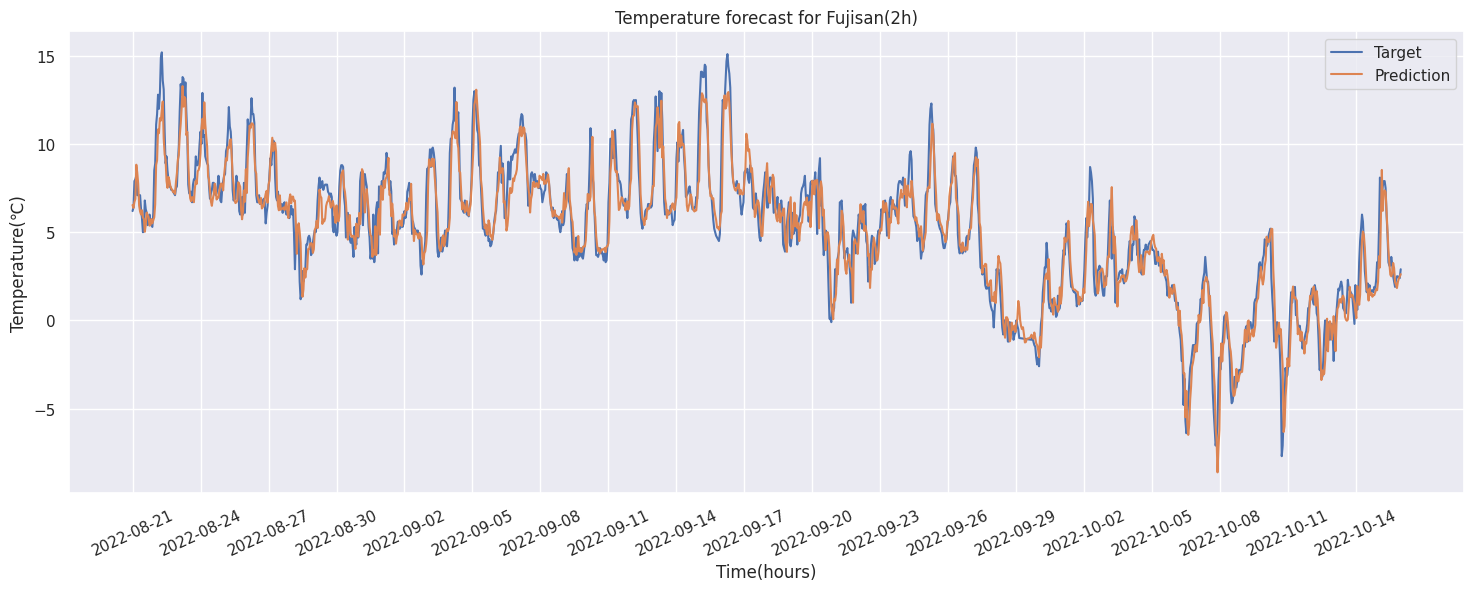

In [14]:
fixed_params = {'patience' : 15,
                'verbose' : 20,
                'n_estimators' : 10000}

runner_lgtop.run_val(fixed_params, p='f', h=h, savefig=True)

In [15]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : 100}

runner_lgtop.run_train_all(fixed_params)

### Prediction using forecast data

In [16]:
# 2 or 8 hours ahead

testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test(runner_lgtop.model, news_data, f3144_data, runner_lgall.top_cols, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse

,LightGBM,Weathernews,Tenki(3775m)
RMSE,1.08,1.688,1.381


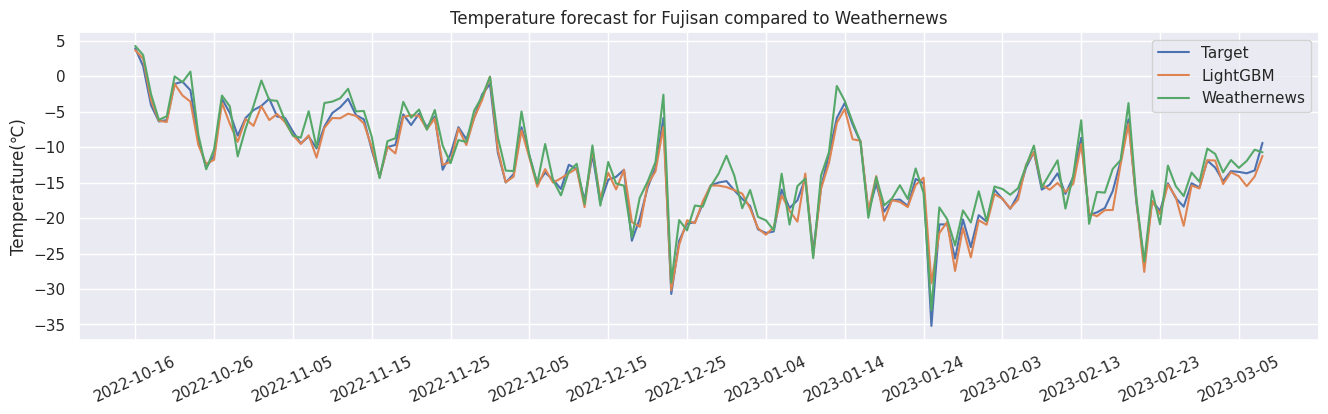

In [17]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to Weathernews', ylabel='Temperature(℃)', s='w', figsize=(16,4), skip=10)

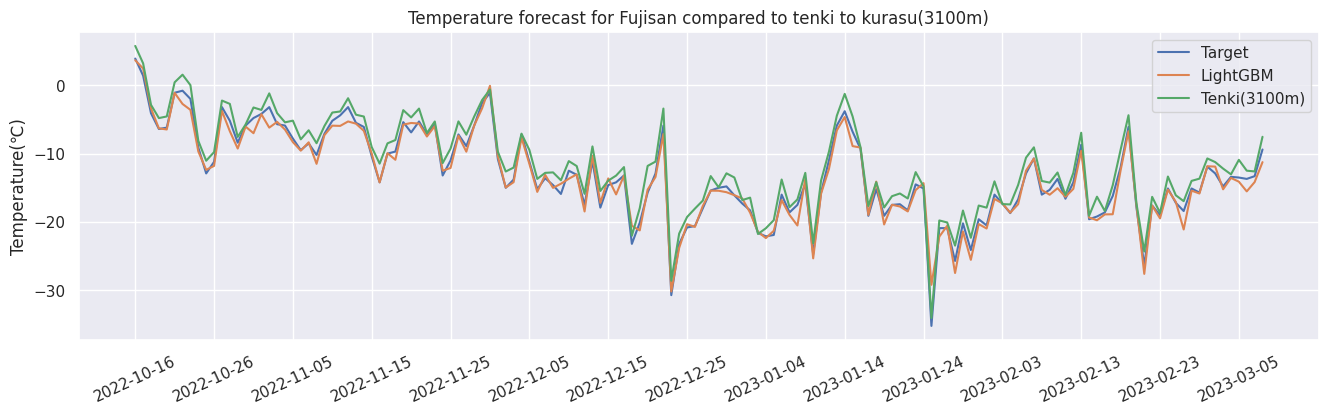

In [18]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to tenki to kurasu(3100m)', ylabel='Temperature(℃)', s='3', figsize=(16,4), skip=10)

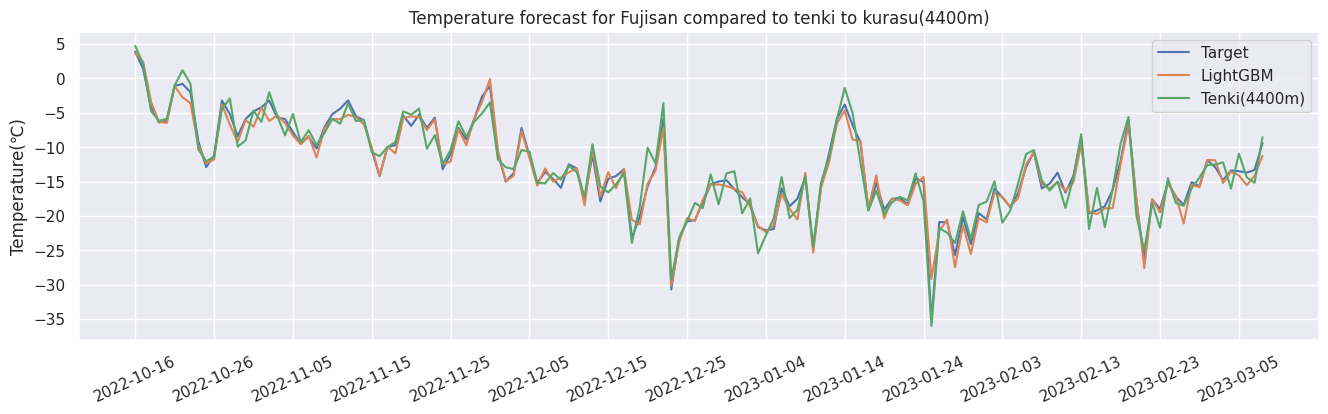

In [19]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to tenki to kurasu(4400m)', ylabel='Temperature(℃)', s='4', figsize=(16,4), skip=10)

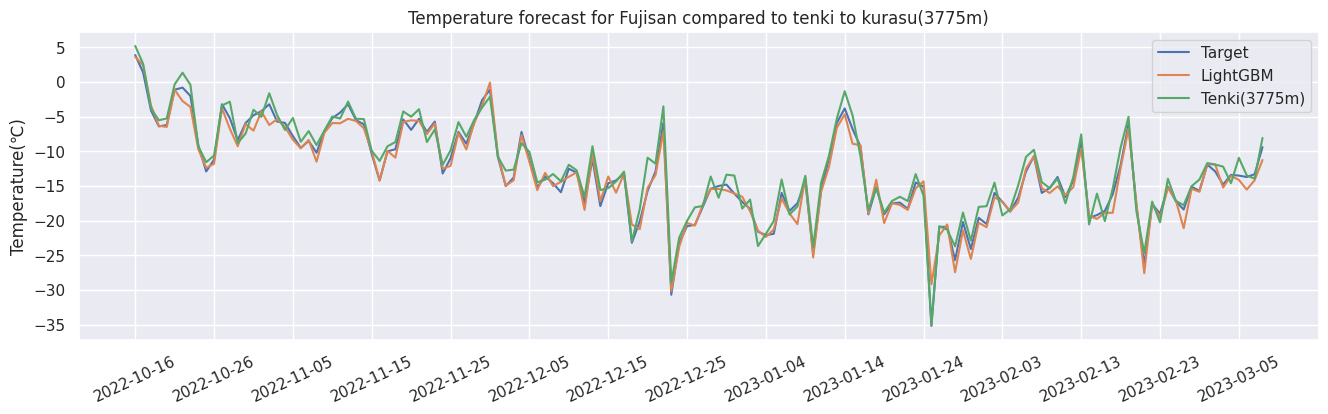

In [20]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to tenki to kurasu(3775m)', ylabel='Temperature(℃)', s='34', figsize=(16,4), skip=10)

In [21]:
# 7 or 9 hours ahead

'''
testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test_without_f3144(runner_lgtop.model, news_data, runner_lgall.top_cols, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse

testrun.plot_test(title='Temperature forecast for Fujisan compared to Weathernews', ylabel='Temperature(℃)', s='w', figsize=(16,4), skip=10)
'''

"\ntestrun = co.TestRun(mf_test_x, mf_test_y)\ntestrun.runf_test_without_f3144(runner_lgtop.model, news_data, runner_lgall.top_cols, ts_time=t, loc='Temperature_Fujisan')\ntestrun.df_rmse\n\ntestrun.plot_test(title='Temperature forecast for Fujisan compared to Weathernews', ylabel='Temperature(℃)', s='w', figsize=(16,4), skip=10)\n"

# Precipitation prediction for Hakone

In [22]:
h='(2h)'
t='09:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_2h_nofuture,t)

'''
h='(7h)'
t='14:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_7h_nofuture,t)

h='(8h)'
t='15:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_8h_nofuture,t)

h='(9h)'
t='16:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_9h_nofuture,t)
'''

"\nh='(7h)'\nt='14:00:00'\nh_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_7h_nofuture,t)\n\nh='(8h)'\nt='15:00:00'\nh_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_8h_nofuture,t)\n\nh='(9h)'\nt='16:00:00'\nh_train_x_all, h_train_y, h_test_x, h_test_y = md.make_no_future_dataset(dataset,md.get_data_hk_9h_nofuture,t)\n"

## lightgbm_all_feature

In [23]:
custom_loss, custom_val = co.create_custom_loss(a=16.0, alpha=0.7)  # regression if alppha=1.0

[I 2023-08-25 13:04:13,747] A new study created in memory with name: no-name-6ed8fdfa-c444-48ae-8588-935a3ae70a37
[I 2023-08-25 13:04:14,841] Trial 0 finished with value: 1.0587349057036082 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.0587349057036082.
[I 2023-08-25 13:04:15,847] Trial 1 finished with value: 1.0689411654897676 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.0587349057036082.
[I 2023-08-25 13:04:17,284] Trial 2 finished with value: 1.09017572760672 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.0587349057036082.
[I 2023-08-25 13:04:18,396] Trial 3 finished with value: 1.0548978508618838 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 's

best params {'num_leaves': 34, 'colsample_bytree': 0.35, 'subsample': 0.30000000000000004, 'min_child_samples': 24, 'max_depth': 6}
best score 1.039


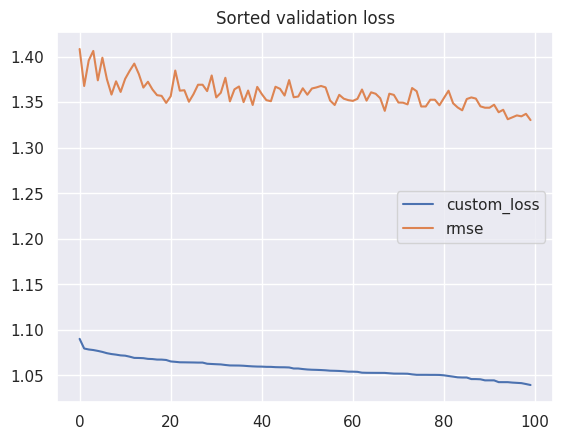

In [24]:
def bayes_objective_h(Model, tr_split, va_split, fixed_params, history = {'val_loss':[], 'rmse':[]}):
    def objective(trial):
        params = {
          'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
          'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
          'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
          'max_depth': trial.suggest_int('max_depth', 5, 10, step=1),
          }

        rmse, val_loss = co.get_scores(Model, tr_split=tr_split, va_split=va_split,
                                         fixed_params=fixed_params, params = params)

        history['val_loss'].append(val_loss)
        history['rmse'].append(rmse)
        return  val_loss
    return objective

fixed_params = {'patience' : 10,
          'verbose' : 1,
          'n_estimators' : 10000,
          'objective': custom_loss,
          "metric" : custom_val,
          }

runner_lgall = co.Runner(model.Lgbm, h_train_x_all, h_train_y)
runner_lgall.run_opt(bayes_objective_h, fixed_params, n_trials=100, seed=42)

Custom val loss 0.5008535731959675
RMSE 0.6110665912985188


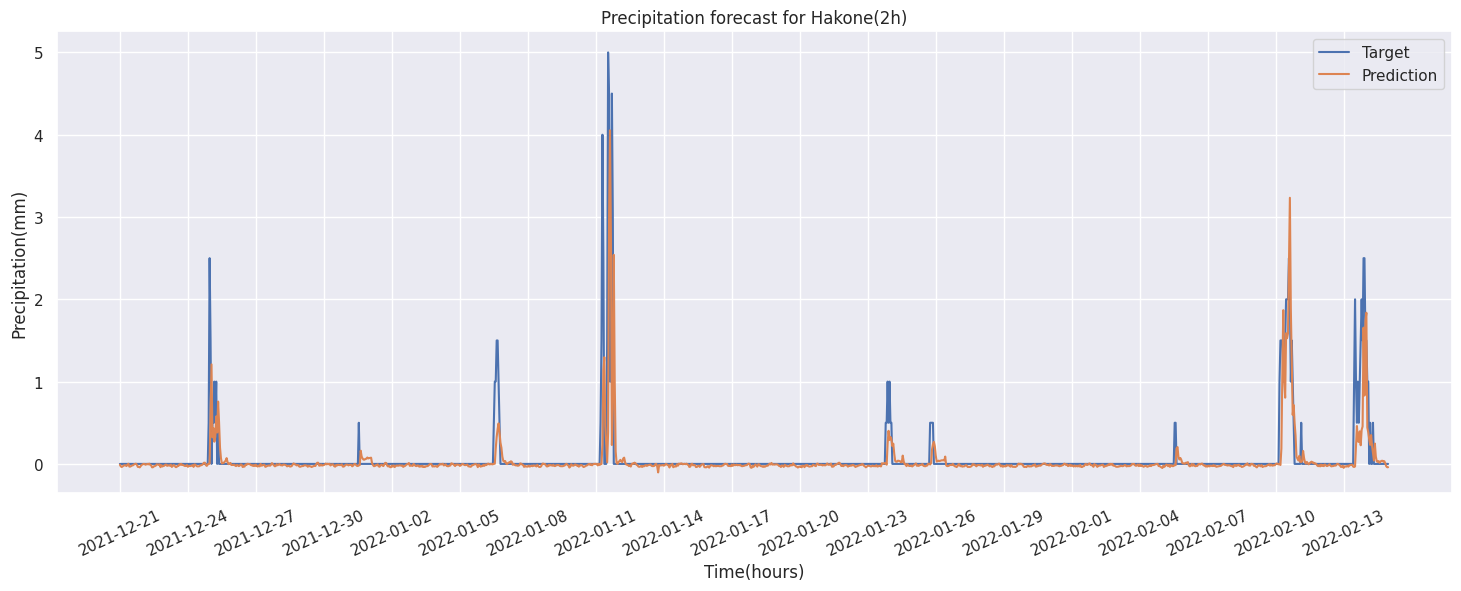

Custom val loss 0.9662751559585954
RMSE 1.246081162347391


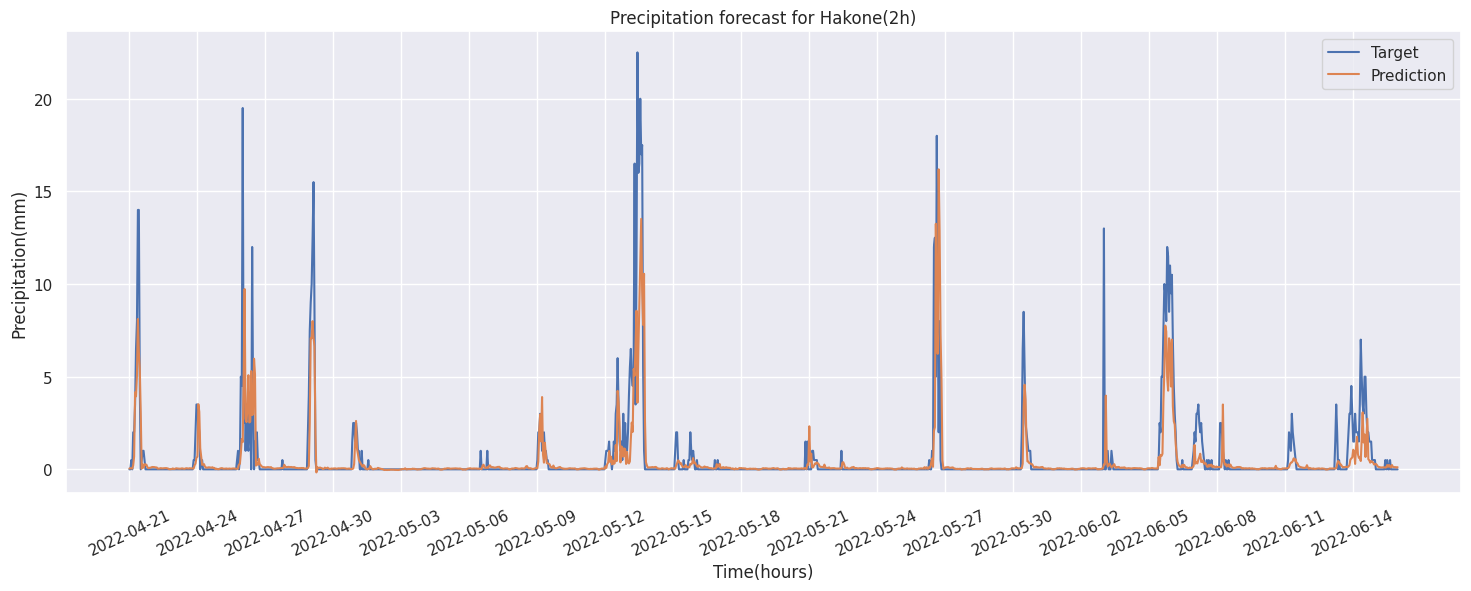

Custom val loss 1.6470383726514164
RMSE 2.125188107438014


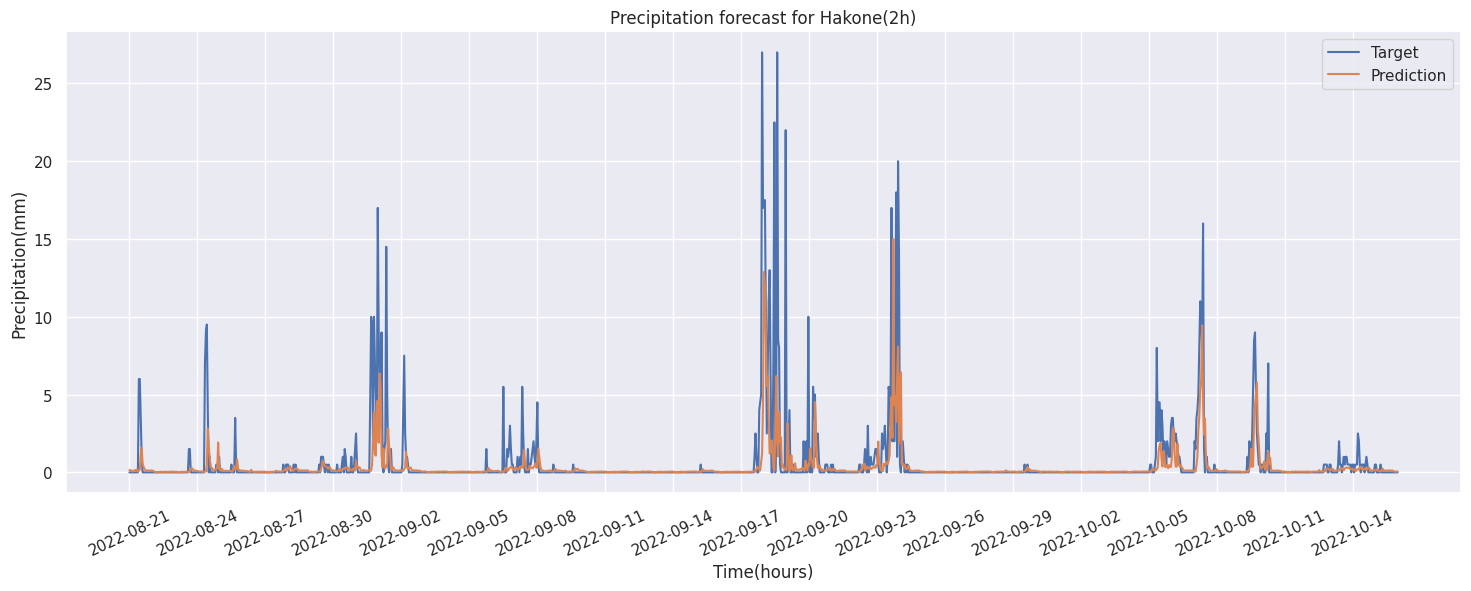

In [25]:
fixed_params = {'patience' : 15,
          'verbose' : 1,
          'n_estimators' : 10000,
          'objective': custom_loss,
          "metric" : custom_val,
          }
runner_lgall.run_val(fixed_params, p='h', h=h)

In [26]:
fixed_params = {'patience' : False,
          'verbose' : 1,
          'n_estimators' : 100,
          'objective': custom_loss,
          "metric" : custom_val,
          }
runner_lgall.run_train_all(fixed_params)

### Prediction using forecast data

In [27]:
testrun = co.TestRun(h_test_x, h_test_y)
testrun.runh_test(runner_lgall.model, news_data, h_test_x.columns, ts_time=t, loc='Precipitation_Hakone')
testrun.df_rmse

,LightGBM,LightGBM_threshold,Weathernews
RMSE,0.743,0.747,0.262


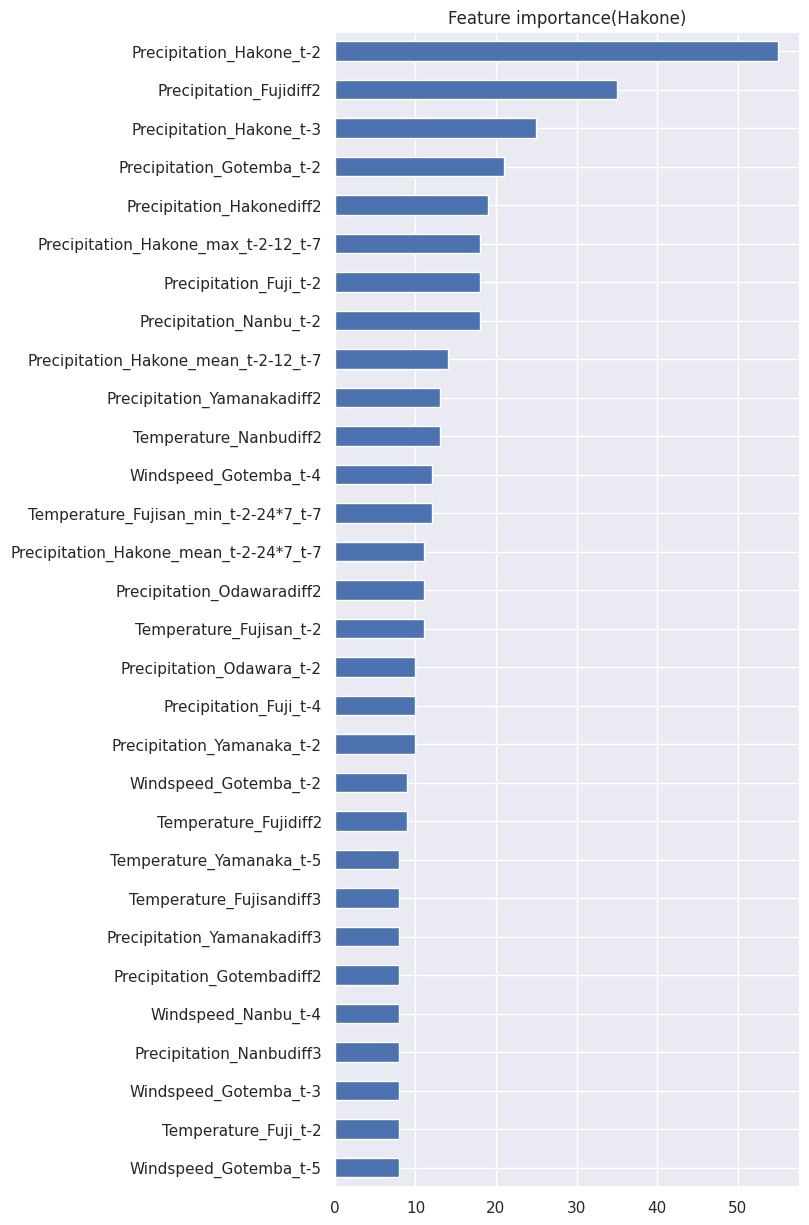

In [28]:
runner_lgall.run_importanace(title='Feature importance(Hakone)', figsize=(6,15), top=30)

In [29]:
runner_lgall.top_cols = np.union1d(np.array(['sin_day', 'cos_day']), runner_lgall.top_cols)

h_train_x_top = h_train_x_all[runner_lgall.top_cols]
h_train_x_top.head()

,Precipitation_Fuji_t-2,Precipitation_Fuji_t-4,Precipitation_Fujidiff2,Precipitation_Gotemba_t-2,Precipitation_Gotembadiff2,Precipitation_Hakone_max_t-2-12_t-7,Precipitation_Hakone_mean_t-2-12_t-7,Precipitation_Hakone_mean_t-2-24*7_t-7,Precipitation_Hakone_t-2,Precipitation_Hakone_t-3,...,Temperature_Fujisandiff3,Temperature_Nanbudiff2,Temperature_Yamanaka_t-5,Windspeed_Gotemba_t-2,Windspeed_Gotemba_t-3,Windspeed_Gotemba_t-4,Windspeed_Gotemba_t-5,Windspeed_Nanbu_t-4,cos_day,sin_day
2019-07-03 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083333,0.0,0.0,...,-0.4,-0.3,21.5,2.1,2.0,2.6,2.7,2.8,0.998667,0.05162
2019-07-03 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083333,0.0,0.0,...,0.2,0.0,22.2,3.0,2.1,2.0,2.6,2.5,0.998667,0.05162
2019-07-03 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083333,0.0,0.0,...,0.4,-0.8,21.2,2.1,3.0,2.1,2.0,2.9,0.998667,0.05162
2019-07-03 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083333,0.0,0.0,...,0.8,-0.3,21.0,3.2,2.1,3.0,2.1,2.5,0.998667,0.05162
2019-07-03 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083333,0.0,0.0,...,-0.3,-0.8,21.0,2.4,3.2,2.1,3.0,1.8,0.998667,0.05162


## lightgbm

[I 2023-08-25 13:06:27,694] A new study created in memory with name: no-name-5cd68eb1-9db0-4124-9ff7-b41484c0abc7
[I 2023-08-25 13:06:28,100] Trial 0 finished with value: 1.0653427862030254 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.0653427862030254.
[I 2023-08-25 13:06:28,663] Trial 1 finished with value: 1.0696492210046156 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.0653427862030254.
[I 2023-08-25 13:06:30,999] Trial 2 finished with value: 1.0951840559920063 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.0653427862030254.
[I 2023-08-25 13:06:31,851] Trial 3 finished with value: 1.0610002863356294 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 

best params {'num_leaves': 39, 'colsample_bytree': 0.4, 'subsample': 0.65, 'min_child_samples': 33, 'max_depth': 7}
best score 1.033


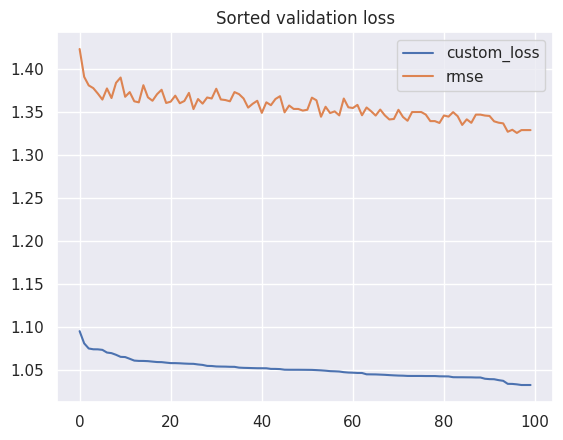

In [30]:
fixed_params = {'patience' : 10,
          'verbose' : 1,
          'n_estimators' : 10000,
          'objective': custom_loss,
          'metric' : custom_val,
          }

runner_lgtop = co.Runner(model.Lgbm, h_train_x_top, h_train_y)
runner_lgtop.run_opt(bayes_objective_h, fixed_params, n_trials=100, seed=42)

Custom val loss 0.5018805687188687
RMSE 0.6224485730900121


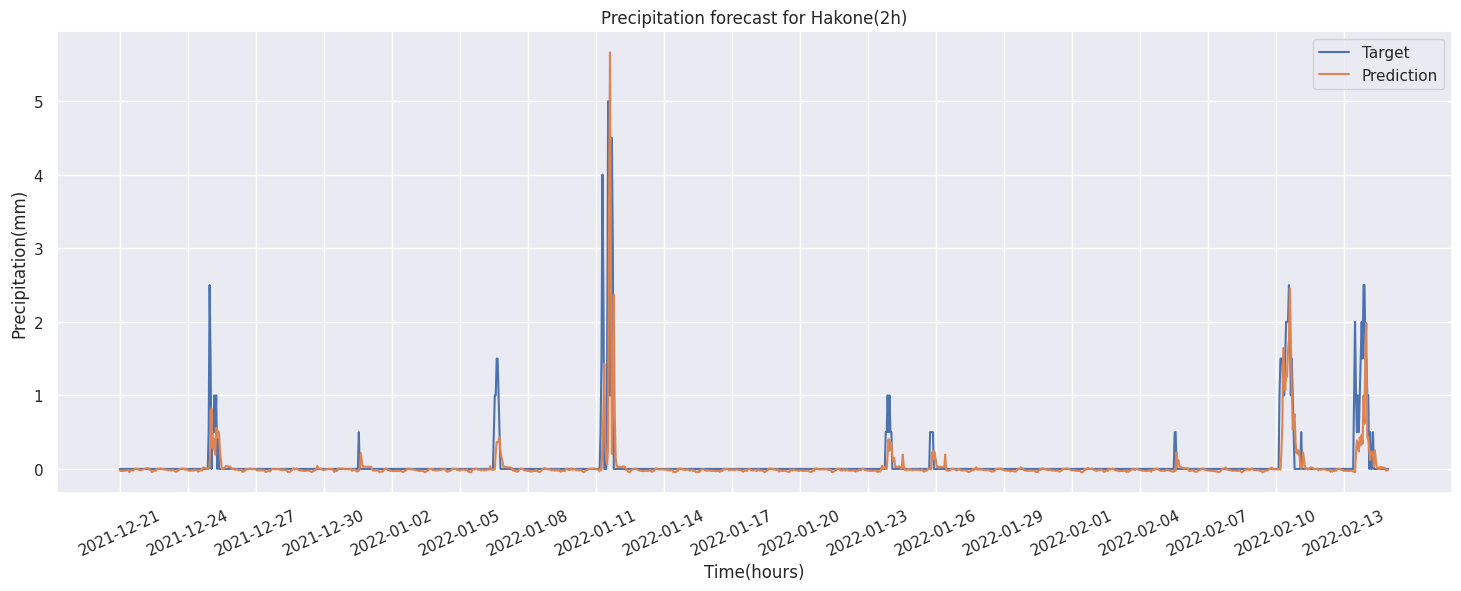

Custom val loss 0.9520890522007458
RMSE 1.2287817085728243


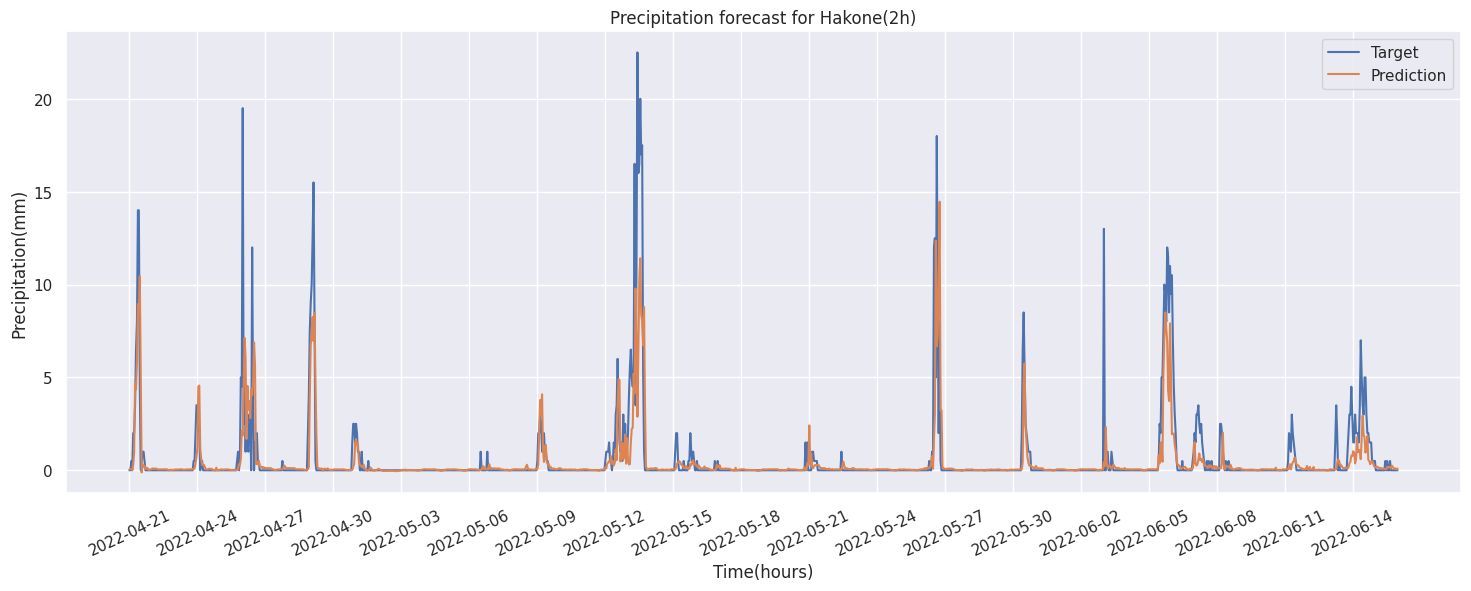

Custom val loss 1.6440051560450681
RMSE 2.134658535232929


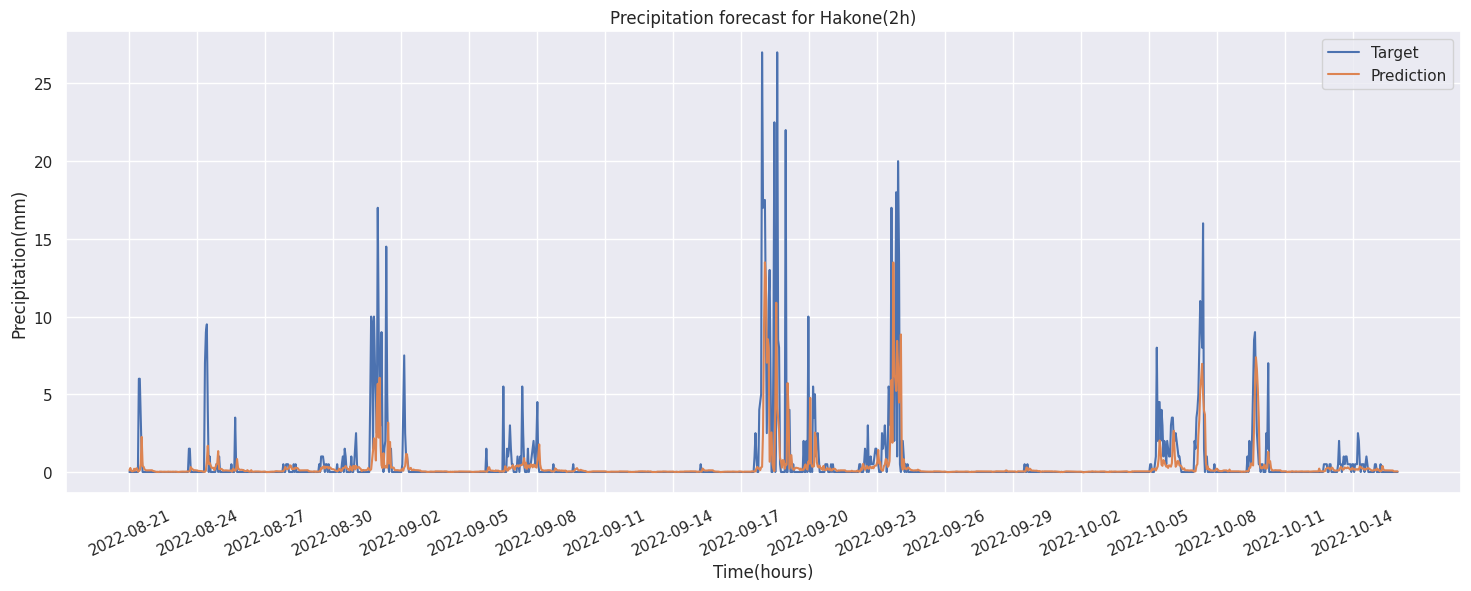

In [31]:
fixed_params = {'patience' : 15,
          'verbose' : 20,
          'n_estimators' : 10000,
          'objective': custom_loss,
          'metric' : custom_val,
          }

runner_lgtop.run_val(fixed_params, p='h', h=h, savefig=True)

In [32]:
fixed_params = {'patience' : False,
                'verbose' : 1,
                'n_estimators' : 100,
                'objective': custom_loss,
                "metric" : custom_val,
                }

runner_lgtop.run_train_all(fixed_params)

### Prediction using forecast data

In [33]:
testrun = co.TestRun(h_test_x, h_test_y)
testrun.runh_test(runner_lgtop.model, news_data, runner_lgall.top_cols, ts_time=t, loc='Precipitation_Hakone')
testrun.df_rmse

,LightGBM,LightGBM_threshold,Weathernews
RMSE,1.204,1.205,0.262


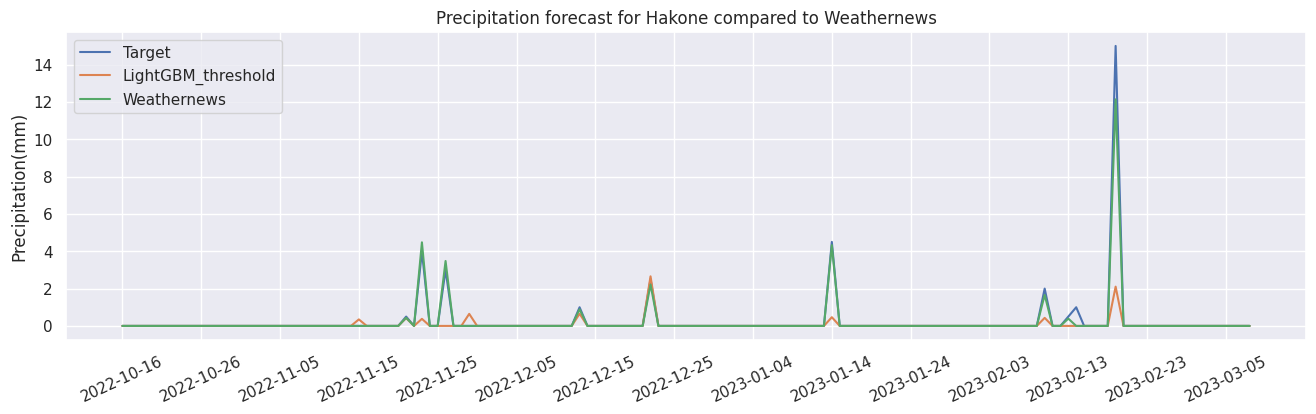

In [34]:
testrun.plot_test(title='Precipitation forecast for Hakone compared to Weathernews',
                  ylabel='Precipitation(mm)', s='w', figsize=(16,4), skip=10, threshold=True)

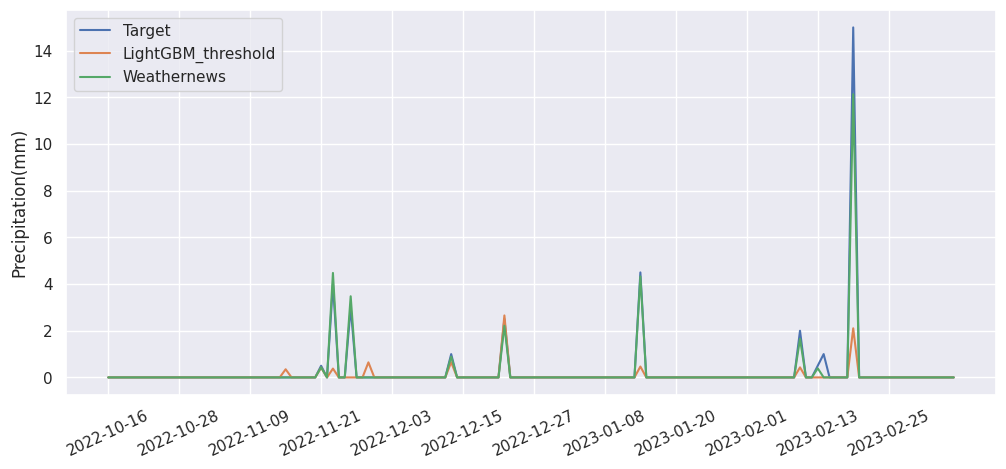

In [35]:
testrun.plot_test(title=False, ylabel='Precipitation(mm)', s='w', figsize=(12,5), skip=12, threshold=True)